In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('../Resources/chicago_marathon_2018.csv')
df.head()

,place_overall,place_gender,bib,name,division,half,finish
0,1,1,1,"Farah, Mo (GBR)",35-39,1:03:06,2:05:11
1,2,2,2,"Bayih, Mosinet Geremew (ETH)",25-29,1:03:04,2:05:24
2,3,3,3,"Osako, Suguru (JPN)",25-29,1:03:04,2:05:50
3,4,4,4,"Kipkemoi, Kenneth (KEN)",30-34,1:03:04,2:05:57
4,5,5,5,"Rupp, Galen (USA)",30-34,1:03:04,2:06:21


In [3]:
df['country'] = df['name'].str.extract('\((.{3})\)')
df = df.dropna()
df.head()

,place_overall,place_gender,bib,name,division,half,finish,country
0,1,1,1,"Farah, Mo (GBR)",35-39,1:03:06,2:05:11,GBR
1,2,2,2,"Bayih, Mosinet Geremew (ETH)",25-29,1:03:04,2:05:24,ETH
2,3,3,3,"Osako, Suguru (JPN)",25-29,1:03:04,2:05:50,JPN
3,4,4,4,"Kipkemoi, Kenneth (KEN)",30-34,1:03:04,2:05:57,KEN
4,5,5,5,"Rupp, Galen (USA)",30-34,1:03:04,2:06:21,USA


In [4]:
df['country'].value_counts().head(20)

USA    13822
MEX     1221
GBR      911
CHN      812
CAN      729
BRA      627
GER      356
ESP      344
ITA      342
FRA      315
IND      275
JPN      235
CRC      222
HKG      218
COL      192
AUS      184
IRL      177
TWN      170
ARG      170
NED      157
Name: country, dtype: int64

In [5]:
df['country'] = df['country'].apply(lambda x: x if x in ('USA', 'MEX', 'GBR', 'CHN', 'CAN') else 'Other')

In [6]:
df[['half','finish']] = df[['half','finish']].apply(pd.to_timedelta).apply(lambda x: x.dt.total_seconds())

In [7]:
X = df[['half','finish', 'division', 'country']].copy()
X['division'] = LabelEncoder().fit_transform(X['division'])
X['country'] = LabelEncoder().fit_transform(X['country'])
X = X.dropna()
X.head()

,half,finish,division,country
0,3786.0,7511.0,4,2
1,3784.0,7524.0,2,4
2,3784.0,7550.0,2,4
3,3784.0,7557.0,3,4
4,3784.0,7581.0,3,5


In [8]:
# Scale the dataset using MinMaxScaler()
X_scaled = MinMaxScaler().fit_transform(X)
X_scaled

array([[2.19170076e-04, 0.00000000e+00, 3.07692308e-01, 4.00000000e-01],
       [7.30566920e-05, 5.18237991e-04, 1.53846154e-01, 8.00000000e-01],
       [7.30566920e-05, 1.55471397e-03, 1.53846154e-01, 8.00000000e-01],
       ...,
       [6.76870251e-01, 9.45026909e-01, 7.69230769e-01, 1.00000000e+00],
       [6.60432496e-01, 9.49212677e-01, 6.92307692e-01, 1.00000000e+00],
       [6.79208065e-01, 1.00000000e+00, 5.38461538e-01, 1.00000000e+00]])

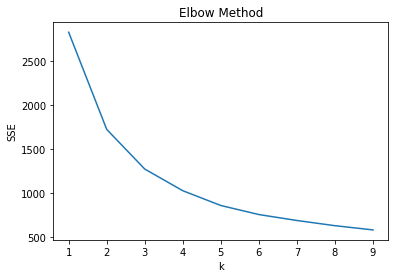

In [9]:
sse = {}
K = range(1, 10)
for k in K:
    kmeanmodel = KMeans(n_clusters=k).fit(X_scaled)
    sse[k]= kmeanmodel.inertia_
    
# Plot
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [10]:
# Create a KMeans model with 3 clusters
model = KMeans(n_clusters=3, random_state=42).fit(X_scaled)

In [11]:
# Calculate predicted values.
y_pred = model.predict(X_scaled)

In [12]:
# Add prediected values onto the original dataframe
df_y = pd.DataFrame(y_pred, columns=['Cluster'])
combined = df.join(df_y, how='inner')
combined.head()

,place_overall,place_gender,bib,name,division,half,finish,country,Cluster
0,1,1,1,"Farah, Mo (GBR)",35-39,3786.0,7511.0,GBR,2
1,2,2,2,"Bayih, Mosinet Geremew (ETH)",25-29,3784.0,7524.0,Other,0
2,3,3,3,"Osako, Suguru (JPN)",25-29,3784.0,7550.0,Other,0
3,4,4,4,"Kipkemoi, Kenneth (KEN)",30-34,3784.0,7557.0,Other,0
4,5,5,5,"Rupp, Galen (USA)",30-34,3784.0,7581.0,USA,0


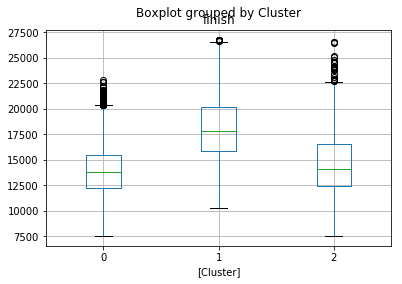

In [13]:
# Plot boxplots of the official time distributions by cluster
combined.boxplot(['finish'], by=['Cluster'])

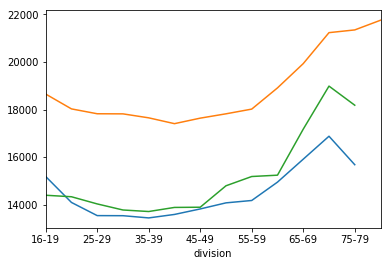

In [14]:
# Plot median finish times by division for each cluster
combined[combined['Cluster'] == 0].groupby('division').median()['finish'].plot()
combined[combined['Cluster'] == 1].groupby('division').median()['finish'].plot()
combined[combined['Cluster'] == 2].groupby('division').median()['finish'].plot()